# 概要
## 内容：店舗・商品別に販売数の予測を行うモデルの構築。2015年11月分が対象
## 目的：予測器を使って、販売数を予測し、在庫切れや過剰供給を防ぐことができるようにする

## 1.ライブラリの読み込み

In [24]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 
from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

### 本分析で利用する関数

In [6]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

## 2.データの読み込み

In [16]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('data/test.csv').set_index('ID')

## 3.データ探索

### 各ファイルのデータの個数・データ型・メモリ容量の確認

In [17]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [18]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [19]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [47]:
train.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB


### 統計情報

In [39]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [41]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [42]:
cats.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [46]:
### item_priceとitem_cnt_dayがマイナスになっている。返品が発生した模様
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [44]:
test.describe()

,shop_id,item_id
count,214200.000000,214200.000000
mean,31.642857,11019.398627
std,17.561933,6252.644590
min,2.000000,30.000000
25%,16.000000,5381.500000
50%,34.500000,11203.000000
75%,47.000000,16071.500000
max,59.000000,22167.000000


### 外れ値チェック
#### 日別商品数


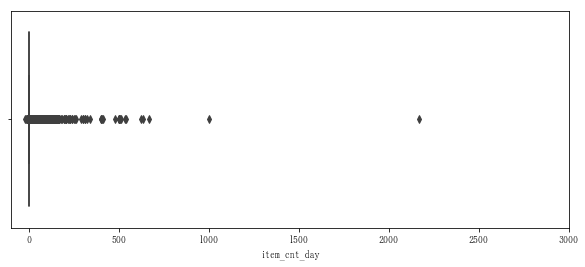

In [28]:
# 日別商品数
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

#### 価格

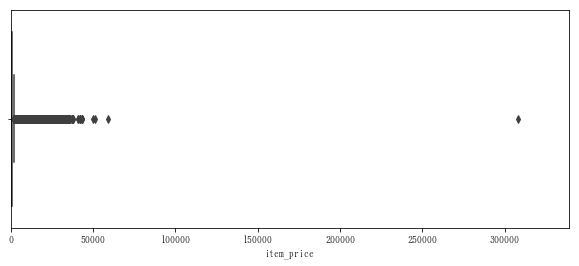

In [29]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [55]:
# 0と57(!マークあるなし）、1と58(!マークあるなし）、10と11（末尾が？と2）が同じ内容になっている
# {チャネル名大カテゴリ}  {チャネル名中カテゴリ} {チャネル名小カテゴリ}
# Сергиев Посад ТЦ "7Я"' だけ上記の形式ではない
pd.DataFrame(shops["shop_name"].unique())

,0
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""
5,"Вологда ТРЦ ""Мармелад"""
6,"Воронеж (Плехановская, 13)"
7,"Воронеж ТРЦ ""Максимир"""
8,"Воронеж ТРЦ Сити-Парк ""Град"""
9,Выездная Торговля


## 4.データ前処理

### 外れ値の削除

In [56]:
train = train[train.item_price<50000]
train = train[train.item_cnt_day<1001]

### 見出し語変換（同じ意味を持つ単語は統一する）

In [57]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## 5.特徴量エンジニアリング
### 店舗データからchannel, channel code を作る
### 商品カテゴリからcategory type, subtype を作る

In [60]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['channel'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.channel == '!Якутск', 'channel'] = 'Якутск'
shops['channel_code'] = LabelEncoder().fit_transform(shops['channel'])
shops = shops[['shop_id','channel_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

### 学習データとテストデータの件数差分確認

In [61]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

### 学習するときと予測するときで、テストと学習データに差分が出ないように商品ID・店舗IDに紐付ける特徴量をまとめたデータを作成する
### データ容量を抑えるために、ダウンキャストする

In [62]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

13.593677043914795

### 販売数と価格を掛け算して、収益カラムを作る

In [63]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

### 正解データは今回月次単位の販売数になるので、月次単位に集計する

In [64]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

6.257190227508545

### 検証データのdate_block_numは34（2015年11月に当たる番号）になるので、値を34になる
### データ容量を抑えるために、データ型を変更する

In [65]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

### 予測するのに必要な特徴量をまとめたデータと検証データを結合

In [66]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.15729784965515137

### 学習に必要な特徴量をまとめたデータに店舗・商品・商品カテゴリの各データを結合させる
### channel_code, item_category_id, type_code, subtype_code のデータ型を型変換する

In [67]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['channel_code'] = matrix['channel_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

6.215111970901489

### 時系列分析

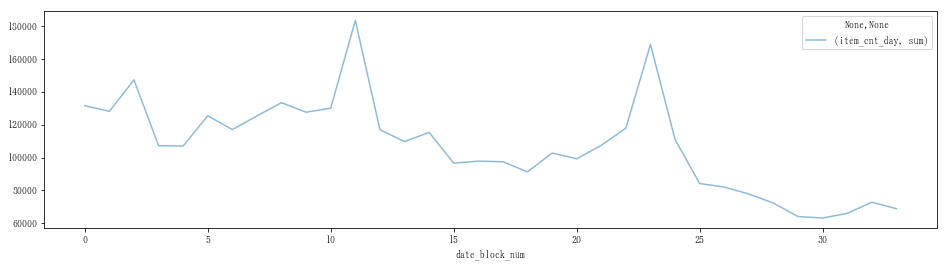

In [89]:
## 時系列で周期性がある
group = train.groupby(['date_block_num']).agg({'item_cnt_day': ['sum']})
group.plot(y = ['item_cnt_day'], figsize=(16,4), alpha=0.5)

### 時系列分析で、属性に時系列データを掛け合わせて新たな特徴量を作るための関数
### 実験的な特徴量

In [92]:
# 元データのlagsヶ月後のデータを特徴量として、追加する
def base_lag_feature(df, lags, col):
        tmp = df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        return df

# 時系列データと特徴量を掛け合わせて、新たな特徴量を作る
def add_grouped_feature(matrix, grpcol, aggcol, method, featurename, lag):

    def lag_feature(df, lags, col):
        tmp = df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        return df

    group = matrix.groupby(grpcol).agg({aggcol: method})
    group.columns = [featurename]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=grpcol, how='left')
    matrix[featurename] = matrix[featurename].astype(np.float16)
    matrix = lag_feature(matrix, lag, featurename)
    matrix.drop(featurename, axis=1, inplace=True)

    return matrix

### 1, 2, 3, 6, 12ヶ月後の商品数のデータを特徴量を作る

In [94]:
ts = time.time()
matrix = base_lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

44.25354886054993

### 時系列と特徴量を掛け合わせた特徴量を作る

In [95]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num'], 'item_cnt_month', 'mean', "date_avg_item_cnt",  [1])
time.time() - ts

15.924127340316772

In [96]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'mean', "date_item_avg_item_cnt",  [1,2,3,6,12])
time.time() - ts

54.28641104698181

In [97]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'mean', "date_shop_avg_item_cnt",  [1,2,3,6,12])
time.time() - ts

59.579267263412476

In [98]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'mean', "date_cat_avg_item_cnt",  [1])
time.time() - ts

20.28762698173523

In [99]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'mean', "date_shop_cat_avg_item_cnt",  [1])
time.time() - ts

23.286646127700806

In [100]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id', 'type_code'], 'item_cnt_month', 'mean', "date_shop_type_avg_item_cnt",  [1])
time.time() - ts

24.001283884048462

In [102]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'channel_code'], 'item_cnt_month', 'mean', "date_city_avg_item_cnt",  [1])
time.time() - ts

22.292996883392334

In [103]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_id', 'channel_code'], 'item_cnt_month', 'mean', "date_item_city_avg_item_cnt",  [1])
time.time() - ts

37.2376389503479

In [104]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'type_code'], 'item_cnt_month', 'mean', "date_type_avg_item_cnt",  [1])
time.time() - ts

24.54386019706726

In [105]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'mean', "date_subtype_avg_item_cnt",  [1])
time.time() - ts

22.708595037460327

### 平均単価を日付ブロック・商品IDの組み合わせ別に算出し、それを特徴量として追加する

In [106]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = base_lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

559.5600550174713

### 収益を日付ブロック・商品IDの組み合わせ別に算出し、それを特徴量として追加する

In [107]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = base_lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

31.227524995803833

### date_block_numから月情報を抽出し、追加する

In [108]:
matrix['month'] = matrix['date_block_num'] % 12

### 月情報と各月の日数をマッピングして特徴量として追加する

In [109]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### 最後に店舗で売れた日付を特徴量として追加

In [110]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1412.2742891311646

### 最後に商品が売れた日付を特徴量として追加

In [111]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

767.0053288936615

### 初回に売れた日付を特徴料として追加

In [112]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.9120800495147705

In [113]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

2.649855136871338

### 商品の販売数の欠損値補完

In [114]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

6.477842092514038

### カラムの確認

In [115]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'channel_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
       'delta_price_lag', 'delta_revenue_lag_1', 'month', 'days',
       'it

### データのタイプ・欠損値確認

In [116]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639246 entries, 4488710 to 11127955
Data columns (total 39 columns):
date_block_num                       int8
shop_id                              int8
item_id                              int16
item_cnt_month                       float16
channel_code                         int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
date_avg_item_cnt_lag_1              float16
date_item_avg_item_cnt_lag_1         float16
date_item_avg_item_cnt_lag_2         float16
date_item_avg_item_cnt_lag_3         float16
date_item_avg_item_cnt_lag_6         float16
date_item_avg_item_cnt_lag_12        float16
date_shop_avg_item_cnt_lag_1         float16


# 6.学習データを保存・一時データを削除

### メモリ容量を削減するため、学習に使わないデータを削除
### 学習データはdata.pklとして保存

In [117]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [118]:
data = pd.read_pickle('data.pkl')

In [120]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'channel_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

### 正解データと正解データを分割する
### 検証用データと学習データのそれぞれに行う

In [121]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [122]:
del data
gc.collect();

# 7. 学習
### XGBを使って学習を行う

In [123]:
ts = time.time()

model = XGBRegressor(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=1)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[19:13:31] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.14971	validation_1-rmse:1.11643
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10163	validation_1-rmse:1.07993
[2]	validation_0-rmse:1.06022	validation_1-rmse:1.04939
[3]	validation_0-rmse:1.02477	validation_1-rmse:1.02401
[4]	validation_0-rmse:0.994653	validation_1-rmse:1.002
[5]	validation_0-rmse:0.969238	validation_1-rmse:0.984023
[6]	validation_0-rmse:0.946957	validation_1-rmse:0.968716
[7]	validation_0-rmse:0.928733	validation_1-rmse:0.956426
[8]	validation_0-rmse:0.913276	validation_1-rmse:0.946422
[9]	validation_0-rmse:0.900071	validation_1-rmse:0.938665
[10]	validation_0-rmse:0.888844	validation_1-rmse:0.932457
[11]	validation_0-rmse:0.879229	validatio

2178.0620679855347

# 8.データの予測

In [124]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

# 9. 機械学習の重要な変数確認

### 重要度の高い特徴量をグラフ化して、どの要素が予測する際、重要な変数かを確認する

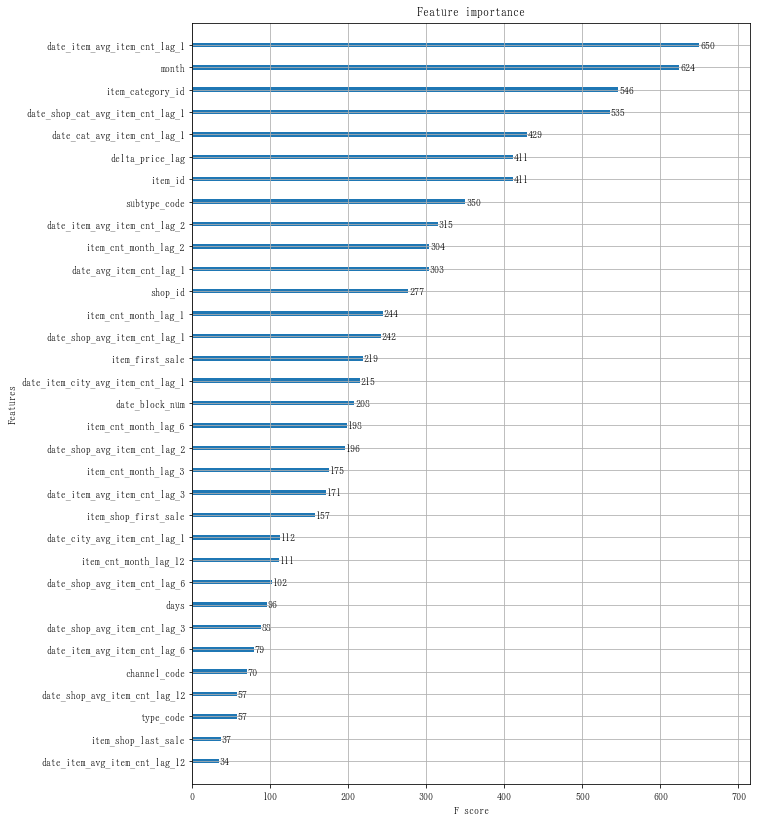

In [125]:
plot_features(model, (10,14))